# Algoritmo SIFT (Scale-Invariant Feature Transform)

En este notebook exploraremos el funcionamiento del algoritmo SIFT, una técnica robusta para detectar y describir puntos de interés en imágenes de manera invariante frente a cambios de escala, rotación y variaciones en la iluminación. SIFT representa una evolución de los métodos tradicionales de detección de bordes y esquinas, enriquecida con un proceso descriptivo que facilita la comparación de características entre distintas imágenes.

Además, evaluaremos la eficiencia del algoritmo en la predicción de la presencia de peatones en fotografías, empleando para ello un modelo SVM de machine learning.


### Paso 1: Cargar y Mostrar la Imagen

Antes de comenzar con el algoritmo, debemos de importar las librerías necesarias y cargar la imagen con la que vamos a trabajar.

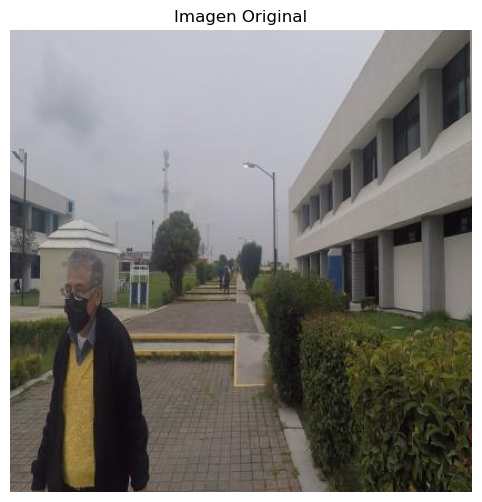

In [1]:
import cv2
import matplotlib.pyplot as plt
import algoritmos.sift as sf  


ruta_imagen1 = '../src/images/test/GOPR0141_MP4-195_jpg.rf.5ed66cd884da63e15b570f0db8d88740.jpg'
ruta_imagen2 = '../src/images/test/MOV_0568_mp4-1_jpg.rf.d1bccc744a8581d054d1ceb3c95f9a30.jpg'

img = cv2.imread(ruta_imagen1)

plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Imagen Original")
plt.axis("off")
plt.show()

### Paso 2: Convertir la Imagen a Escala de Grises

Convertir la imagen a escala de grises simplifica el procesamiento al reducir la cantidad de información de color, centrándose solo en las intensidades. Esto es útil porque:
- **Reducción de Complejidad:** Se elimina la información de color (RGB), lo que reduce la complejidad de la imagen sin perder la información estructural esencial.
- **Detección de Características:** Los cambios en la intensidad son fundamentales para detectar bordes, esquinas y otras características, que son la base para identificar a continuación keypoints con SIFT.
- **Eficiencia Computacional:** Al trabajar con una sola canal (grises) en lugar de tres (color), se reduce la carga computacional.

Aunque SIFT internamente convierte la imagen a escala de grises, realizar esta conversión explícitamente permite visualizar mejor el proceso y verificar manualmente el preprocesamiento de la imagen.

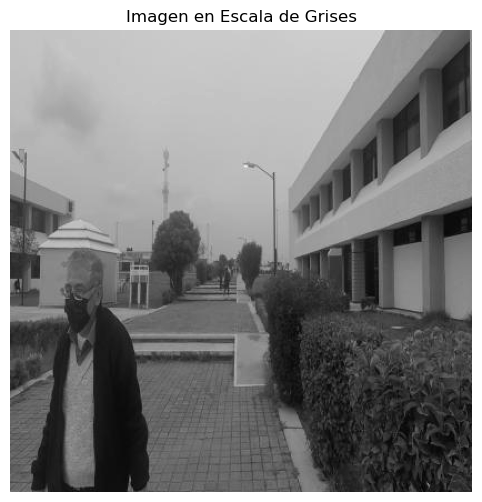

In [2]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


plt.figure(figsize=(8,6))
plt.imshow(img_gray, cmap='gray')
plt.title("Imagen en Escala de Grises")
plt.axis("off")
plt.show()

### Paso 3: Configuración del Detector SIFT

En este paso se definen y configuran los parámetros del detector SIFT:

- **nfeatures:** Número máximo de características a detectar (0 significa detectar todas).
- **nOctaveLayers:** Número de capas por octava.
- **contrastThreshold:** Umbral para descartar características de bajo contraste.
- **edgeThreshold:** Umbral para eliminar puntos en bordes poco definidos.
- **sigma:** Desviación estándar inicial para el filtro Gaussiano.

Posteriormente, se crea el objeto SIFT utilizando la clase definida en el módulo `algoritmos/sift.py`.


In [3]:
nfeatures = 5            # 0 = detectar todas las características posibles
nOctaveLayers = 3        # Número de capas por octava
contrastThreshold = 0.04 # Umbral para descartar características de bajo contraste
edgeThreshold = 10       # Umbral para descartar características en bordes
sigma = 1.6              # Desviación estándar inicial para el filtro Gaussiano



algo_sift = sf.sift_detect(nfeatures, nOctaveLayers, contrastThreshold, edgeThreshold, sigma)

### Paso 4: Construcción de la Pirámide Gaussiana en SIFT

Cuando construimos la pirámide gaussiana, realizamos sucesivas convoluciones de la imagen con filtros gausianos de distinta **sigma** (desviación estándar) y reducimos la resolución de la imagen en cada “octava”. El objetivo es **analizar la imagen en diferentes escalas**, permitiendo detectar características (keypoints) que sean invariantes ante cambios de tamaño y desenfoque.

A continuación, se explica el proceso de manera didáctica, apoyándonos en la formulación matemática de la convolución Gaussiana y en ejemplos.

---

#### 1. Fundamento Matemático del Filtro Gaussiano

La función gaussiana 2D (en coordenadas $x, y$) se define como:

$$
G(x, y, \sigma) = \frac{1}{2 \pi \sigma^2} \exp\Bigl(-\frac{x^2 + y^2}{2\sigma^2}\Bigr)
$$

Donde:
- $\sigma$ es la **desviación estándar**, que controla el nivel de desenfoque.
- $x, y$ son las coordenadas espaciales respecto al centro del kernel gaussiano.

Para cada **nivel** de la pirámide, se **convoluciona** la imagen $I$ con este filtro $G$ para obtener una versión suavizada:

$$
I_{\text{gauss}}(x, y, \sigma) = I(x, y) * G(x, y, \sigma)
$$

donde $*$ denota la operación de convolución.

---

#### 2. Concepto de “Octavas” y “Niveles”

1. **Octavas:**  
   Cada octava representa una reducción de la resolución de la imagen a la mitad de sus dimensiones (tanto en ancho como en alto). Por ejemplo, si la imagen original tiene una resolución de $416 \times 416$, en la siguiente octava la imagen se reduce a $208 \times 208$, y así sucesivamente.  

2. **Niveles (o Escalas) dentro de cada octava:**  
   Dentro de cada octava, se generan varias versiones de la imagen aplicando diferentes grados de desenfoque gaussiano.
   - Cada nivel aumenta el valor de $\sigma$ progresivamente, produciendo imágenes cada vez más “suaves”.

---

#### 3. Ejemplo Ilustrativo de la Pirámide Gaussiana

Supongamos que en la primera octava (Octava 0) la imagen se mantiene en la resolución original $416 \times 416$. A cada nivel se le aplica un filtro gaussiano con distinta $\sigma$. Podemos representarlo así:

- **Octava 0:**  
  - Nivel 0: $\sigma_0 = 1.6$  
  - Nivel 1: $\sigma_1 = k \cdot \sigma_0$  
  - Nivel 2: $\sigma_2 = k^2 \cdot \sigma_0$  
  - …  
  - Nivel 5: $\sigma_5 = k^5 \cdot \sigma_0$  

  donde $k$ es un factor que depende del número de niveles por octava.

- **Octava 1:**  
  - La imagen se reduce a la mitad de la resolución: $208 \times 208$.  
  - Se aplican de nuevo varios filtros gausianos con valores de $\sigma$ escalados.

- **Octava 2, Octava 3, …**  
  - Se repite el mismo proceso, reduciendo cada vez la resolución a la mitad y variando $\sigma$.

---

#### 4. ¿Para Qué Sirve?

1. **Detección de Características en Múltiples Escalas:**  
   Al observar la imagen en distintos niveles de desenfoque y resoluciones, SIFT puede encontrar puntos de interés que sean **invariantes** ante cambios de tamaño o desenfoque. Esto significa que un objeto grande o lejano (que aparezca pequeño en la imagen) se puede detectar con el mismo método.

2. **Preparación para la Pirámide de Diferencia de Gaussianos (DoG):**  
   Posteriormente, se construye la pirámide **DoG** (Difference of Gaussians), donde se restan imágenes consecutivas de la pirámide gaussiana para realzar los cambios de intensidad. Esa pirámide DoG es la que se emplea para localizar los **keypoints**.

Octava 0:
  Nivel 0: resolución (416, 416)
  Nivel 1: resolución (416, 416)
  Nivel 2: resolución (416, 416)
  Nivel 3: resolución (416, 416)
  Nivel 4: resolución (416, 416)
  Nivel 5: resolución (416, 416)
Octava 1:
  Nivel 0: resolución (208, 208)
  Nivel 1: resolución (208, 208)
  Nivel 2: resolución (208, 208)
  Nivel 3: resolución (208, 208)
  Nivel 4: resolución (208, 208)
  Nivel 5: resolución (208, 208)
Octava 2:
  Nivel 0: resolución (104, 104)
  Nivel 1: resolución (104, 104)
  Nivel 2: resolución (104, 104)
  Nivel 3: resolución (104, 104)
  Nivel 4: resolución (104, 104)
  Nivel 5: resolución (104, 104)
Octava 3:
  Nivel 0: resolución (52, 52)
  Nivel 1: resolución (52, 52)
  Nivel 2: resolución (52, 52)
  Nivel 3: resolución (52, 52)
  Nivel 4: resolución (52, 52)
  Nivel 5: resolución (52, 52)


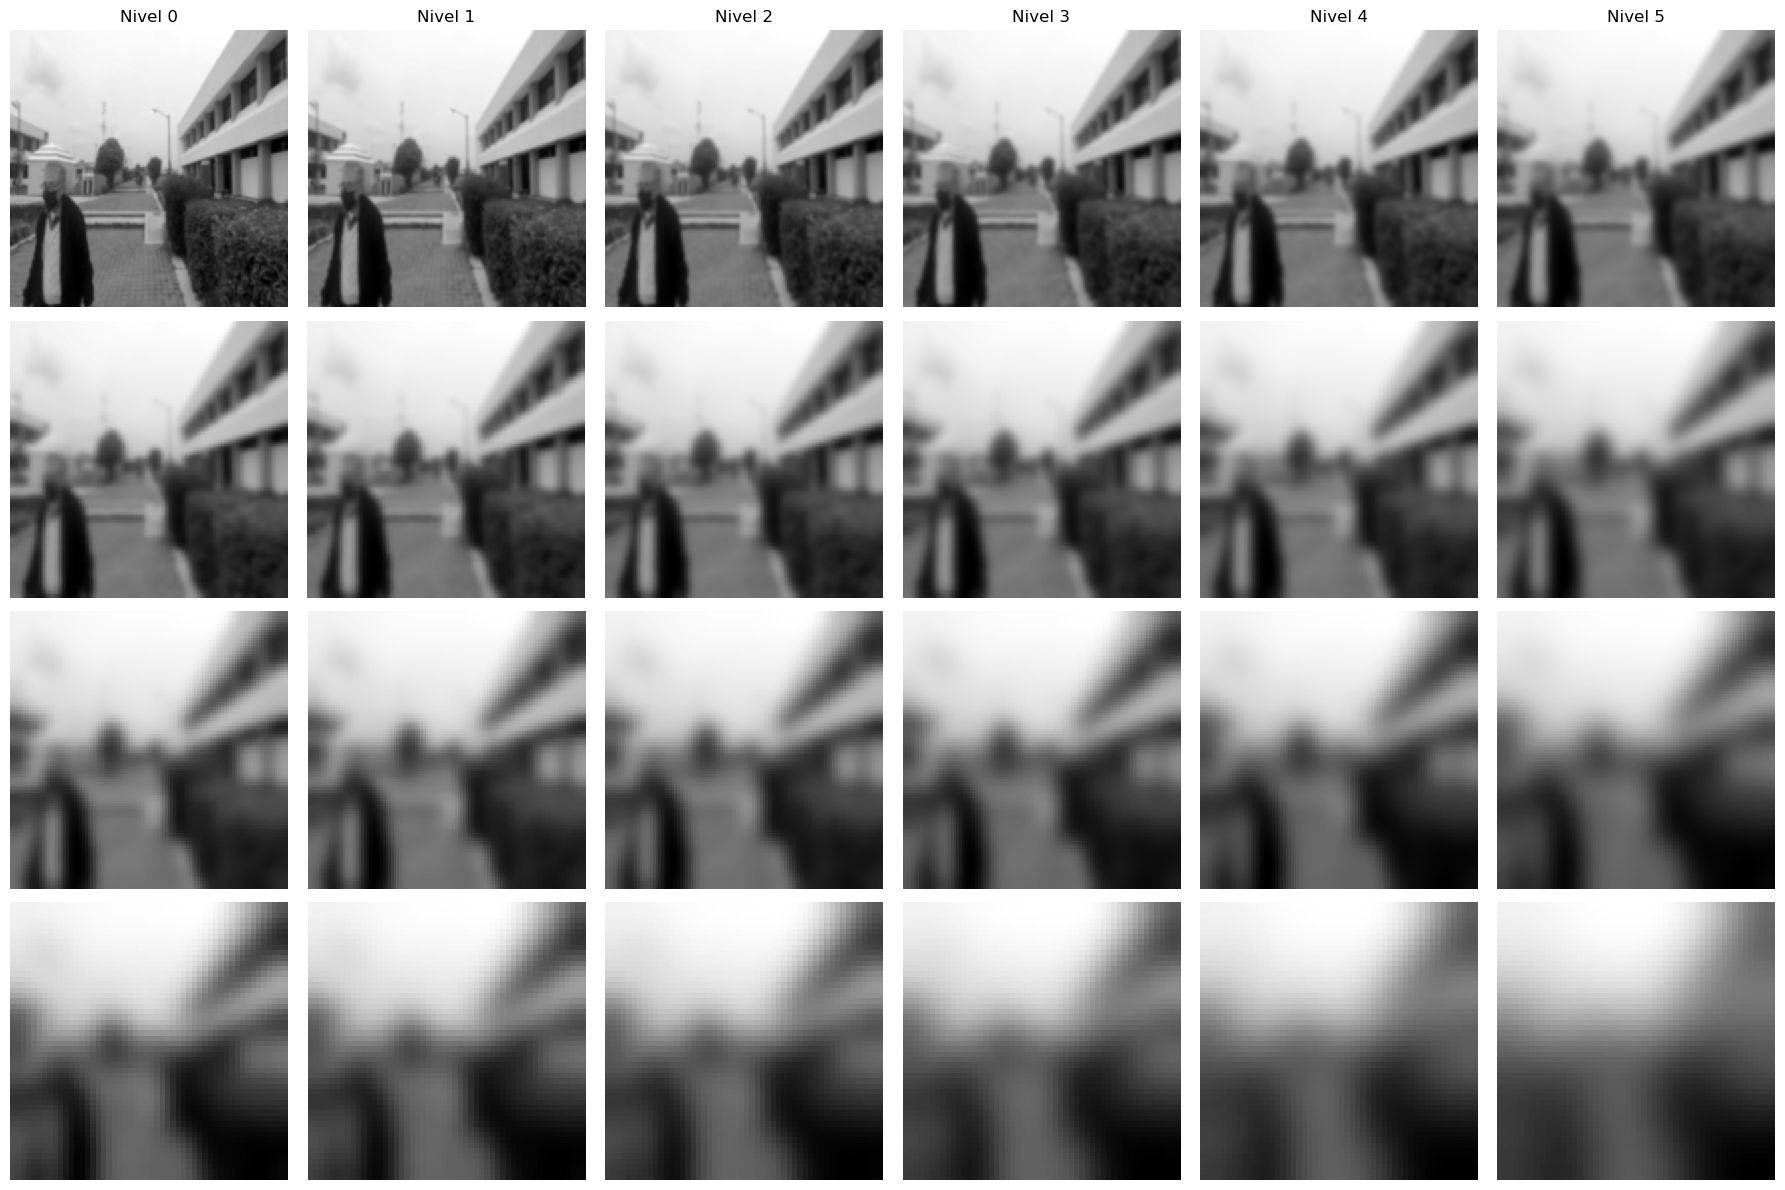

In [4]:
gray = algo_sift.to_grayscale_float32(img)
gaussian_pyr = algo_sift.build_gaussian_pyramid(gray, num_octaves=4, num_scales=3, sigma=1.6)
algo_sift.show_gaussian_pyramid(gaussian_pyr)

### Paso 5: Construcción y Visualización de la Pirámide DoG

Después de generar la pirámide gaussiana en diferentes escalas, el siguiente paso en SIFT es construir la pirámide de Diferencia de Gaussianos (DoG). Esta pirámide se obtiene restando imágenes consecutivas de la pirámide gaussiana, lo que resalta las variaciones de intensidad entre niveles de suavizado. Esto es clave para detectar los puntos de interés (keypoints) que serán usados en etapas posteriores.

---

#### 1. Fundamento Matemático de la Pirámide DoG

Para dos imágenes gausianas sucesivas, suavizadas con parámetros $\sigma_1$ y $\sigma_2$, la imagen DoG se calcula como:

$$
\text{DoG}(\sigma_1, \sigma_2) = G(x, y, \sigma_1) - G(x, y, \sigma_2)
$$

donde $G(x, y, \sigma)$ es el resultado de la convolución de la imagen con el filtro gaussiano definido por:

$$
G(x, y, \sigma) = \frac{1}{2 \pi \sigma^2} \exp\Bigl(-\frac{x^2 + y^2}{2\sigma^2}\Bigr)
$$

Esta operación de resta resalta los cambios sutiles en la intensidad de la imagen que ocurren entre dos niveles de desenfoque consecutivos.

---

#### 2. Proceso de Construcción de la Pirámide DoG

1. **Dentro de Cada Octava:**  
   En cada octava de la pirámide gaussiana se tienen múltiples niveles con distintos valores de $\sigma$. Por ejemplo, si en una octava tenemos niveles con:
   
   - Nivel 0: $\sigma_0 = 1.6$
   - Nivel 1: $\sigma_1 = k \cdot \sigma_0$
   - Nivel 2: $\sigma_2 = k^2 \cdot \sigma_0$
   - $\dots$
   - Nivel 5: $\sigma_5 = k^5 \cdot \sigma_0$
   
   se calcula la DoG entre imágenes consecutivas:

   $$
   \text{DoG}_k = G(x, y, \sigma_k) - G(x, y, \sigma_{k+1})
   $$

2. **Entre Octavas:**  
   Una vez procesados todos los niveles en una octava, se reduce la resolución de la imagen (generalmente a la mitad en cada dimensión) para iniciar la siguiente octava y se repite el proceso de suavizado y resta. Por ejemplo, si la imagen original tiene una resolución de $416 \times 416$, en la siguiente octava la resolución será $208 \times 208$, y así sucesivamente.

---

#### 3. ¿Para Qué Sirve la Pirámide DoG?

1. **Localización de Extremos Locales:**  
   La DoG facilita la detección de extremos locales en el espacio y a lo largo de la escala. Esto significa que al calcular la diferencia entre dos imágenes suavizadas (con distintos valores de sigma), se resaltan los puntos en los que hay cambios significativos en la intensidad. Dichos puntos, denominados extremos locales, son aquellos que destacan porque su valor (más claro o más oscuro) difiere notablemente del de sus vecinos en el espacio (la imagen) y en diferentes niveles de desenfoque (la escala). Estos extremos son considerados candidatos a keypoints porque, al representar características distintivas de la imagen (como esquinas o bordes), son útiles para emparejar y reconocer objetos en diferentes condiciones.

2. **Invariancia a Escala:**  
   Al identificar características que se mantienen constantes a través de distintas escalas, el algoritmo SIFT puede detectar los mismos puntos de interés incluso si el objeto aparece en tamaños diferentes.

---

#### 4. Visualización de la Pirámide DoG

Al visualizar la pirámide DoG se pueden observar los contornos y estructuras resaltadas por las diferencias entre niveles de suavizado. Cada imagen DoG en una octava tiene la misma resolución, pero muestra diferencias en el desenfoque, lo que permite identificar claramente los cambios de intensidad que indican la presencia de posibles keypoints.

In [5]:
dog_pyr = algo_sift.build_dog_pyramid(gaussian_pyr)

algo_sift.show_dog_pyramid(dog_pyr)

Octava 0:
  Nivel 0: resolución (416, 416)
  Nivel 1: resolución (416, 416)
  Nivel 2: resolución (416, 416)
  Nivel 3: resolución (416, 416)
  Nivel 4: resolución (416, 416)
Octava 1:
  Nivel 0: resolución (208, 208)
  Nivel 1: resolución (208, 208)
  Nivel 2: resolución (208, 208)
  Nivel 3: resolución (208, 208)
  Nivel 4: resolución (208, 208)
Octava 2:
  Nivel 0: resolución (104, 104)
  Nivel 1: resolución (104, 104)
  Nivel 2: resolución (104, 104)
  Nivel 3: resolución (104, 104)
  Nivel 4: resolución (104, 104)
Octava 3:
  Nivel 0: resolución (52, 52)
  Nivel 1: resolución (52, 52)
  Nivel 2: resolución (52, 52)
  Nivel 3: resolución (52, 52)
  Nivel 4: resolución (52, 52)


### Paso 6: Detección de Keypoints

Este bloque de código se ejecuta después del procesamiento previo, que incluye la construcción de la pirámide gaussiana y la pirámide DoG para resaltar las variaciones de intensidad a diferentes escalas. Gracias a este procesamiento, los keypoints se detectan de forma precisa al identificar extremos locales en las imágenes DoG.

- **Detección de Keypoints:**  
  Se utiliza la función `detect_keypoints` para identificar los puntos clave en la imagen en escala de grises (`img_gray`). La detección se basa en el análisis de la pirámide DoG, donde se buscan los extremos locales.  
  Se imprime el número de keypoints detectados.

- **Visualización de Keypoints:**  
  Los keypoints detectados se dibujan sobre la imagen en escala de grises utilizando `cv2.drawKeypoints`, resaltándolos en color rojo.  

  Finalmente, se muestra la imagen resultante con los keypoints mediante Matplotlib, sin ejes y con el título "Keypoints detectados".


Número de keypoints detectados: 5


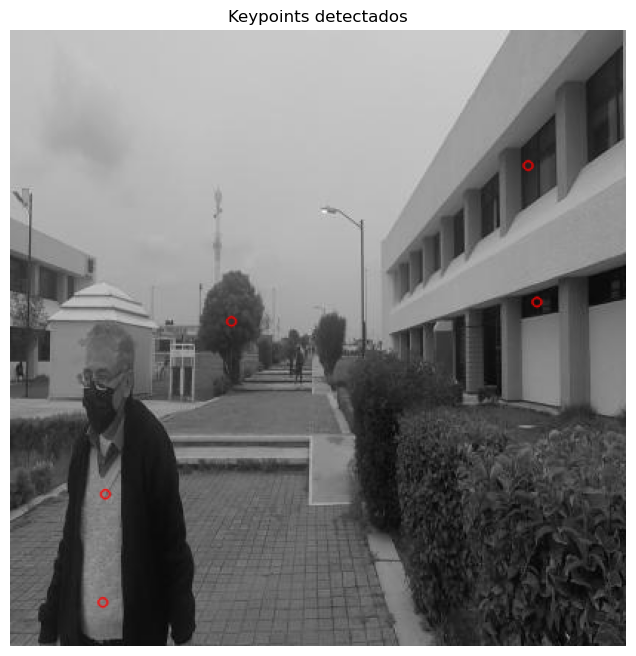

In [6]:
keypoints = algo_sift.detect_keypoints(img_gray)
print("Número de keypoints detectados:", len(keypoints))

img_with_keypoints = cv2.drawKeypoints(img_gray, keypoints, None, color=(0, 0, 255))



plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title("Keypoints detectados")
plt.axis('off')
plt.show()



### Paso 7: Asignación de Orientación a los Keypoints

En este paso, a cada keypoint se le asigna una orientación basándose en el análisis de cómo cambian los tonos en la región cercana al punto. Esto significa que se determina hacia qué dirección varían los tonos de la imagen alrededor del keypoint, lo que permite que la comparación de características sea consistente incluso si la imagen se rota. Este proceso es crucial, ya que permite que los descriptores calculados posteriormente, sean robustos frente a rotaciones, garantizando que la comparación entre imágenes sea consistente sin importar la orientación de los objetos.


En SIFT, la asignación de la orientación de un keypoint se realiza mediante el análisis de cómo varían los tonos en la región inmediata alrededor del punto. El proceso es el siguiente:

1. **Cálculo de Gradientes:**  
   Se calcula la magnitud y la dirección del cambio de intensidad en cada píxel dentro de una región circular centrada en el keypoint.

2. **Construcción de un Histograma:**  
   Con la información de los gradientes, se crea un histograma donde se acumulan las direcciones (ángulos) de todos los píxeles dentro de la región. Cada píxel contribuye al histograma con un peso que normalmente depende de la magnitud del gradiente y de su proximidad al centro (se usa una función gaussiana para dar más peso a los píxeles cercanos al keypoint).

3. **Selección de la Orientación Dominante:**  
   Se analiza el histograma para encontrar el pico principal, es decir, la dirección en la que se concentra la mayor parte de los gradientes. Esa dirección se asigna como la orientación principal del keypoint. 
      - En algunos casos, si existen otros picos secundarios que sean significativamente altos (por ejemplo, que tengan un valor al menos 80% del pico principal), se pueden asignar orientaciones adicionales, creando múltiples keypoints en la misma posición pero con diferentes orientaciones.
 

   
Gracias a la orientación, permitirá a los descriptores calcular la información de los gradientes con esta dirección. Esto garantiza que, incluso si la imagen se rota, los descriptores comparan la misma estructura relativa, haciendo que la detección y emparejamiento sean robustos ante cambios de orientación.



In [7]:

if len(keypoints) > 0:
    # Elegir un keypoint
    kp = keypoints[3]
    # Obtener sus coordenadas (x, y)
    x, y = kp.pt 
    print("Coordenadas del keypoint:", x, y)
    x, y = int(x), int(y)
    
    # Definir el tamaño del patch alrededor del keypoint
    patch_size = 100
    half_patch = patch_size // 2
    
    # Asegurarse de no salir del límite de la imagen:
    x_start = max(0, x - half_patch)
    x_end   = min(gray.shape[1], x + half_patch)
    y_start = max(0, y - half_patch)
    y_end   = min(gray.shape[0], y + half_patch)
    # Extraer la ventana (patch) alrededor del keypoint
    patch = gray[y_start:y_end, x_start:x_end]
    
    # Demostrar el proceso de orientación en el patch
    algo_sift.demonstrate_orientation(patch)
else:
    print("No se detectaron keypoints.")

Coordenadas del keypoint: 63.92593002319336 313.0076904296875


## Paso 8: Mostrar los Keypoints con su Orientación Final

En este paso se dibujan los keypoints detectados sobre la imagen en escala de grises y se muestran utilizando funciones específicas del módulo SIFT:

- **Dibujo de Keypoints:**  
  Se utiliza la función `draw_keypoints` para superponer los keypoints sobre la imagen (`img_gray`). Cada keypoint se representa gráficamente por un círculo y una flecha. La flecha indica la orientación asignada y el círculo refleja la escala o el tamaño de la región de interés.

- **Mostrar la Imagen:**  
  La imagen resultante, con los keypoints resaltados, se visualiza mediante la función `show_img_keypoints`, lo que permite inspeccionar visualmente la detección de características y sus orientaciones.

### ¿Por qué algunos keypoints tienen círculos de mayor tamaño que otros?

El tamaño del círculo que rodea un keypoint está relacionado con la **escala** en la que se detectó ese punto. Esto se debe a lo siguiente:

 **Escala del Keypoint:**  
   
   Durante el proceso de construcción de la pirámide gaussiana, la imagen se analiza a diferentes escalas. Cada keypoint se detecta en una escala particular, que indica el tamaño relativo de la característica en la imagen.
   
   El radio del círculo que se dibuja para un keypoint suele ser proporcional a la escala en la que se detectó. Por ejemplo, si un keypoint se detecta en un nivel de la pirámide con una desviación estándar $\sigma$, es común representar este keypoint con un círculo cuyo radio está relacionado con $\sigma$.  
   
   Matemáticamente, podríamos expresar el radio del círculo como:
   
   $$
   r = k \cdot \sigma
   $$
   
   donde $k$ es un factor de escala que permite visualizar la diferencia entre keypoints detectados a distintas escalas.

 **Interpretación:**  
   - Un keypoint con un círculo de mayor tamaño indica que la característica fue detectada en una escala más grande, lo que puede corresponder a una estructura o patrón de mayor tamaño en la imagen.  
   - Por el contrario, un keypoint con un círculo pequeño sugiere que se detectó en una escala menor, asociada a detalles más finos.



In [8]:
img_keypoints = algo_sift.draw_keypoints(img_gray, keypoints)

algo_sift.show_img_keypoints(img_keypoints)

### Paso 9: Cálculo de Descriptores

Una vez que se han determinado la posición, escala y orientación de un keypoint, se extrae un descriptor que captura la distribución de gradientes en la región circundante. Este descriptor es clave para representar de forma robusta la información local y permitir la comparación entre diferentes imágenes.

### Proceso de Extracción del Descriptor

1. **Ventana de Análisis:**  
   Se selecciona una ventana de tamaño $16 \times 16$ píxeles centrada en el keypoint, adaptada a su escala.

2. **División en Celdas:**  
   La ventana se divide en celdas de tamaño $4 \times 4$. Así, la ventana se subdivide en:
   $$
   \frac{16 \times 16}{4 \times 4} = 4 \times 4 \quad \text{celdas.}
   $$

3. **Histograma de Gradientes:**  
   En cada una de las $4 \times 4$ celdas, se calcula un histograma que acumula las magnitudes de los gradientes según 8 orientaciones diferentes. Esto implica que cada celda se describe mediante un vector de 8 dimensiones.

4. **Vector Descriptor:**  
   Al concatenar los histogramas de las 16 celdas, se obtiene un vector descriptor de dimensión:
   $$
   4 \times 4 \times 8 = 128.
   $$

5. **Normalización:**  
   El vector resultante se normaliza para mejorar la robustez frente a cambios de iluminación y contraste.

### Resultado Final

El resultado final del proceso es un conjunto de keypoints, donde cada keypoint cuenta con:
- **Posición:** Coordenadas en la imagen.
- **Escala:** Nivel de zoom relativo.
- **Orientación:** Dirección dominante en la región del keypoint.
- **Descriptor:** Un vector normalizado de 128 dimensiones que resume la distribución de gradientes locales.

Estos descriptores se utilizan para emparejar puntos similares entre diferentes imágenes, lo que facilita tareas como el reconocimiento de objetos, ya que capturan detalles locales robustos frente a variaciones en escala, orientación e iluminación.

In [9]:
descriptors = algo_sift.compute_descriptors(img_gray, keypoints)

if descriptors is not None:
    print("Forma de la matriz de descriptores:", descriptors.shape)
    
plt.figure(figsize=(10, 8))
plt.imshow(descriptors, aspect='auto', cmap='viridis')
plt.colorbar(label='Valor del descriptor')
plt.title("Matriz de Descriptores (128 dimensiones por keypoint)")
plt.xlabel("Dimensión del descriptor (0-127)")
plt.ylabel("Número de keypoint")
plt.show()

Forma de la matriz de descriptores: (5, 128)


### DEMOSTRACIÓN DE INVARIANZA FRENTE A UNA IMAGEN TRANSFORMADA


Para evaluar la invarianza de nuestro algoritmo SIFT, vamos a realizar pruebas aplicando diversas transformaciones a la imagen. La idea es demostrar que, aun cuando la imagen se vea afectada por cambios en rotación, iluminación, contraste o escala, el algoritmo SIFT sigue detectando los mismos keypoints y calculando descriptores consistentes.

Podemos usar cualquiera de los siguientes parámetros de transformación:

- **'rotate90':** Rotación de 90 grados.
- **'rotate180':** Rotación de 180 grados.
- **'rotate45':** Rotación de 45 grados.
- **'lower_illumination':** Reducción de la iluminación.
- **'increase_contrast':** Aumento del contraste.
- **'scale_down':** Escalado descendente (reducción de tamaño).

La función `apply_transformation` definida a continuación nos permite aplicar cualquiera de estas transformaciones a una imagen en escala de grises:

In [10]:
def apply_transformation(img, transformation):
        """
        Aplica una transformación seleccionada a la imagen.
        
        Parámetros:
        - img: Imagen en escala de grises.
        - transformation: Tipo de transformación. Las opciones disponibles son:
            'rotate90'             - Rotación de 90 grados.
            'rotate180'            - Rotación de 180 grados.
            'rotate45'             - Rotación de 45 grados.
            'lower_illumination'   - Reducción de la iluminación.
            'increase_contrast'    - Aumento del contraste.
            'scale_down'           - Escalado descendente (reducción de tamaño).
        
        Devuelve:
        - La imagen transformada.
        """
        (h, w) = img.shape[:2]
        center = (w // 2, h // 2)
        
        if transformation == 'rotate90':
            angle = 90
            scale = 1.0
            M = cv2.getRotationMatrix2D(center, angle, scale)
            transformed = cv2.warpAffine(img, M, (w, h))
            
        elif transformation == 'rotate180':
            angle = 180
            scale = 1.0
            M = cv2.getRotationMatrix2D(center, angle, scale)
            transformed = cv2.warpAffine(img, M, (w, h))
            
        elif transformation == 'rotate45':
            angle = 45
            scale = 1.0
            M = cv2.getRotationMatrix2D(center, angle, scale)
            transformed = cv2.warpAffine(img, M, (w, h))
            
        elif transformation == 'lower_illumination':
            # Reducir el brillo: se resta un valor beta a cada píxel.
            alpha = 1.0  # Sin cambio en el contraste
            beta = -50   # Se reduce la iluminación
            transformed = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
            
        elif transformation == 'increase_contrast':
            # Aumentar el contraste: se multiplica cada píxel por alpha.
            alpha = 1.5  # Aumenta el contraste
            beta = 0     # Sin cambio en el brillo
            transformed = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
        
        elif transformation == 'scale_down':
            # Reducir la escala: se redimensiona la imagen a un porcentaje menor y luego se 
            # vuelve a ajustar al tamaño original para comparar visualmente.
            factor = 0.5  # Escalar al 50%
            scaled = cv2.resize(img, None, fx=factor, fy=factor, interpolation=cv2.INTER_LINEAR)
            transformed = cv2.resize(scaled, (w, h), interpolation=cv2.INTER_LINEAR)
            
        else:
            transformed = img
            
        return transformed

## Cargar, Transformar y Procesar una Imagen

En este ejemplo se carga una imagen, se convierte a escala de grises y se le aplica una transformación seleccionada.

In [11]:
# Cargar la imagen y convertirla a escala de grises
ruta_imagen1 = '../src/images/test/GOPR0141_MP4-195_jpg.rf.5ed66cd884da63e15b570f0db8d88740.jpg'
ruta_imagen2 = '../src/images/test/MOV_0568_mp4-1_jpg.rf.d1bccc744a8581d054d1ceb3c95f9a30.jpg'
img_dem = cv2.imread(ruta_imagen2)
img_original = cv2.cvtColor(img_dem, cv2.COLOR_BGR2GRAY)

# Transformar la imagen. Modos disponibles: 'rotate90', 'rotate180', 'rotate45', 'lower_illumination', 'increase_contrast', 'scale_down'
img_trans = apply_transformation(img_original, transformation='lower_illumination')

## Visualización Lado a Lado de la Imagen Original y Transformada

El siguiente código crea una figura con 2 subplots para mostrar la imagen original en escala de grises y la imagen transformada una al lado de la otra. Esto permite comparar visualmente el efecto de la transformación.


In [12]:
# Crear una figura con 2 subplots para mostrar las imágenes lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].imshow(img_original, cmap='gray')
axes[0].set_title("Imagen Original en Escala de Grises")
axes[0].axis("off")

axes[1].imshow(img_trans, cmap='gray')
axes[1].set_title("Imagen Transformada")
axes[1].axis("off")

# Mostrar la figura completa
plt.show()

## Detección de Keypoints y Descriptores con SIFT

En este ejemplo se vuelve a crear una nueva instancia de SIFT con distintos valores en sus parametros para detectar todos los keypoints y calcular sus descriptores en dos versiones de una imagen: la imagen original y una versión transformada. Luego, se dibujan los keypoints sobre ambas imágenes y se muestran lado a lado para facilitar la comparación.


In [13]:
# Crear una instancia de la clase SIFT
algo_sift_demo = sf.sift_detect(nfeatures=0, nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6)

# Detectar keypoints y calcular descriptores 
keypoints_orig = algo_sift_demo.detect_keypoints(img_original)
descriptors_orig = algo_sift_demo.compute_descriptors(img_original, keypoints_orig)


keypoints_rot = algo_sift_demo.detect_keypoints(img_trans)
descriptors_rot = algo_sift_demo.compute_descriptors(img_trans, keypoints_rot)

# Dibujar keypoints 
img_with_kp_orig = cv2.drawKeypoints(img_original, keypoints_orig, None, color=(0, 0, 255))

img_with_kp_rot = cv2.drawKeypoints(img_trans, keypoints_rot, None, color=(0, 0, 255))



# Crear una figura con dos subplots para visualizar ambas imágenes lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(cv2.cvtColor(img_with_kp_orig, cv2.COLOR_BGR2RGB))
axes[0].set_title("Keypoints - Imagen Original")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(img_with_kp_rot, cv2.COLOR_BGR2RGB))
axes[1].set_title("Keypoints - Imagen Transformada")
axes[1].axis("off")

# Mostrar la figura completa
plt.show()


## Emparejamiento de Descriptores con BFMatcher

El siguiente código muestra cómo emparejar los descriptores de los keypoints obtenidos de la imagen original y la imagen transformada utilizando un matcher de fuerza bruta. Se aplica el ratio test de Lowe para filtrar emparejamientos poco confiables, de modo que solo se conserven los mejores matches.


In [14]:
# Crear un objeto matcher de fuerza bruta
bf = cv2.BFMatcher()

# Calcular los descriptores para la imagen original y la rotada (asumiendo que ya tienes keypoints y descriptores)
# keypoints_orig, descriptors_orig = algo_sift.detect_and_compute(img_gray_original)
# keypoints_rot, descriptors_rot = algo_sift.detect_and_compute(img_gray_rotated)

# Emparejar los descriptores
matches = bf.knnMatch(descriptors_orig, descriptors_rot, k=2)

# Aplicar el ratio test de Lowe para filtrar emparejamientos malos
good_matches = []
for m, n in matches:
    if m.distance < 0.5 * n.distance:
        good_matches.append(m)

# Dibujar los emparejamientos
img_matches = cv2.drawMatches(img_original, keypoints_orig, img_trans, keypoints_rot, good_matches, None, flags=2)
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title("Emparejamientos entre Imagen Original y Transformada")
plt.axis("off")
plt.show()


## Visualización de Keypoints en la Imagen Original y Transformada

El siguiente código dibuja los keypoints detectados sobre ambas imágenes (la original y la transformada) y las muestra lado a lado para facilitar la comparación visual.


In [15]:
# Dibujar keypoints en ambas imágenes
img_keypoints_orig = algo_sift_demo.draw_keypoints(img_original, keypoints_orig)
img_keypoints_rot = algo_sift_demo.draw_keypoints(img_trans, keypoints_rot)

# Crear una figura con dos subplots para visualizar ambas imágenes lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(cv2.cvtColor(img_keypoints_orig, cv2.COLOR_BGR2RGB))
axes[0].set_title("Puntos Clave Detectados - Imagen Original")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(img_keypoints_rot, cv2.COLOR_BGR2RGB))
axes[1].set_title("Puntos Clave Detectados - Imagen Transformada")
axes[1].axis("off")

# Mostrar la figura completa
plt.show()



### ALGORITMO SIFT APLICADO AL RECONOCIMIENTO DE PEATONES USANDO UN MODELO DE MACHINE LEARNING SVM


In [16]:

from utils.sift_svm import sift_svm
from machine_learning.svm import svm
# Definir parámetros para el detector SIFT
parametros_sift = {
    "nfeatures": 0,
    "nOctaveLayers": 3,
    "contrastThreshold": 0.04,
    "edgeThreshold": 10,
    "sigma": 1.6
}
    
# Crear la instancia pasando la función y sus parámetros
classifier = svm(algorithm=sift_svm, algo_params=parametros_sift)
    
# Rutas de datos (modifica según tu estructura)
train_persona_folder = "images/train"       # Contiene imágenes con personas y sus XML
train_no_persona_folder = "images/train_no"   # Imágenes sin personas

val_persona_folder = "images/valid"            # Validación: imágenes con personas y sus XML
val_no_persona_folder = "images/valid_no"        # Validación: imágenes sin personas

test_persona_folder = "images/test"           # Prueba: imágenes con personas y sus XML
test_no_persona_folder = "images/test_no"       # Prueba: imágenes sin personas

In [17]:
classifier.fit(train_persona_folder, train_no_persona_folder,val_persona_folder, val_no_persona_folder)


ROI size: (130,105) (ymin: 65, ymax: 195, xmin: 21, xmax: 126)
ROI size: (166,112) (ymin: 229, ymax: 395, xmin: 101, xmax: 213)
ROI size: (111,96) (ymin: 343, ymax: 454, xmin: 362, xmax: 458)
ROI size: (105,116) (ymin: 337, ymax: 442, xmin: 448, xmax: 564)
ROI size: (109,185) (ymin: 225, ymax: 334, xmin: 70, xmax: 255)
ROI size: (116,145) (ymin: 21, ymax: 137, xmin: 132, xmax: 277)
ROI size: (145,130) (ymin: 235, ymax: 380, xmin: 40, xmax: 170)
ROI size: (121,137) (ymin: 290, ymax: 411, xmin: 334, xmax: 471)
ROI size: (112,164) (ymin: 445, ymax: 557, xmin: 233, xmax: 397)
ROI size: (190,162) (ymin: 263, ymax: 453, xmin: 386, xmax: 548)
ROI size: (188,114) (ymin: 228, ymax: 416, xmin: 90, xmax: 204)
ROI size: (191,110) (ymin: 281, ymax: 472, xmin: 256, xmax: 366)
ROI size: (128,99) (ymin: 204, ymax: 332, xmin: 145, xmax: 244)
ROI size: (171,117) (ymin: 381, ymax: 552, xmin: 59, xmax: 176)
ROI size: (131,181) (ymin: 501, ymax: 632, xmin: 439, xmax: 620)
ROI size: (113,180) (ymin: 52, yma

In [18]:
# Guardar el modelo usando el nombre por defecto (e.g., 'svm_sift.pkl')
classifier.save_model()

Modelo SVM guardado como 'svm_sift.pkl'


In [19]:
modelo="svm_sift.pkl"
classifier.evaluate(test_persona_folder, test_no_persona_folder,modelo)


ROI size: (159,165) (ymin: 411, ymax: 570, xmin: 231, xmax: 396)
ROI size: (179,128) (ymin: 33, ymax: 212, xmin: 140, xmax: 268)
ROI size: (186,127) (ymin: 226, ymax: 412, xmin: 131, xmax: 258)
ROI size: (137,140) (ymin: 361, ymax: 498, xmin: 350, xmax: 490)
ROI size: (164,109) (ymin: 132, ymax: 296, xmin: 126, xmax: 235)
ROI size: (150,134) (ymin: 21, ymax: 171, xmin: 447, xmax: 581)
ROI size: (134,121) (ymin: 474, ymax: 608, xmin: 345, xmax: 466)
ROI size: (145,132) (ymin: 295, ymax: 440, xmin: 199, xmax: 331)
ROI size: (162,100) (ymin: 159, ymax: 321, xmin: 255, xmax: 355)
ROI size: (156,147) (ymin: 159, ymax: 315, xmin: 470, xmax: 617)
ROI size: (119,166) (ymin: 193, ymax: 312, xmin: 95, xmax: 261)
ROI size: (109,152) (ymin: 302, ymax: 411, xmin: 354, xmax: 506)
ROI size: (184,115) (ymin: 181, ymax: 365, xmin: 204, xmax: 319)
ROI size: (170,138) (ymin: 203, ymax: 373, xmin: 325, xmax: 463)
ROI size: (169,185) (ymin: 420, ymax: 589, xmin: 245, xmax: 430)
ROI size: (176,159) (ymin: 1